In [1]:
# Feel free to import any other libraries and modules.
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import nn

# Part One: Optimization Algorithms
## 1. Gradient Descent
The Gradient Descent (GD) algorithm finds the minimum of a given
function by taking small steps along the function's gradient:

>$\Theta \leftarrow \Theta_0$

>**while** stop condition not met **do**

>$~~~~$$\Theta \leftarrow \Theta - \alpha \nabla_\Theta f(\Theta)$

>**end while**

where $f$ is the function to minimize, $\nabla_\Theta f(\Theta)$
denotes $f$'s gradient at $\Theta$ and $\alpha$ is the learning rate.

**Task1:** Implement the GD algorithm as a function:

  \begin{equation}
      \Theta_{opt} = \text{GD}(f, \Theta_0, \alpha, \rho)
  \end{equation}
where $f$ is a function returning the cost and its gradient with respect to parameter vector $\Theta$, $\Theta_0$ is the initial value, and $\alpha$
is the learning rate. You can assume that $\alpha$. remains constant during the optimization. $\rho$ is stop condition. \\
Then, use the GD algorithm to find the optimum of the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function) (Consider $a=1, b=100$).
 \\
Also, plot the values found by GD at subsequent iterations.

## 2. Newton's Method
Newton's method is an iterative optimization algorithm used to find the minimum of a function.
The basic update step in Newton's method is given by:

\begin{equation}
\Theta = \Theta - H^{-1} \cdot \nabla f(\Theta)
\end{equation}


Where  $ H $ is the Hessian matrix of the function at $ \Theta $, and $ H^{-1} $ is the inverse of the Hessian matrix, used to adjust the step size and direction more accurately than just using the gradient alone (as done in gradient descent).

#### Line Search
Sometimes, Newton's method may take too large of a step, which can lead to divergence. To prevent this, a simple **line search** is used. This reduces the step size $ \alpha $ if the function value doesn't improve after the step.

Steps:
1. Compute the gradient and Hessian matrix at the current point.
2. Calculate the step direction by multiplying the inverse of the Hessian with the gradient.
3. Update the point by subtracting the step from the current point.
4. If the function value doesn't improve, reduce the step size $ \alpha $.
5. Repeat until the gradient becomes sufficiently small (close to zero), indicating convergence.



**Task2:** Implement Newton's method and compare it with the gradient descent. You will also need to implement a line search alogithm, e.g. (https://en.wikipedia.org/wiki/Backtracking_line_search) and make sure that the Newton's direction is indeed one along which the function is minimized.


In [2]:
def rosenbrock(x):
    """Returns the value and gradient of Rosenbrock's function at x: 2d vector"""
    a = 1
    b = 100
    x0, x1 = x[0], x[1]

    # Value of the Rosenbrock function
    val = (a - x0)**2 + b * (x1 - x0**2)**2

    # Gradients
    dv_dx0 = -2 * (a - x0) - 4 * b * x0 * (x1 - x0**2)
    dv_dx1 = 2 * b * (x1 - x0**2)

    grad = np.array([dv_dx0, dv_dx1])
    return val, grad

def rosenbrock_hessian(x):
    """Returns the value, gradient and hessian of Rosenbrock's function at x: 2d vector"""
    val, grad = rosenbrock(x)
    a = 1
    b = 100
    x0, x1 = x[0], x[1]

    # Hessian matrix components
    d2v_dx0x0 = 2 - 4 * b * x1 + 12 * b * x0**2
    d2v_dx0x1 = -4 * b * x0
    d2v_dx1x0 = -4 * b * x0
    d2v_dx1x1 = 2 * b

    # Hessian matrix
    hessian = np.array([[d2v_dx0x0, d2v_dx0x1],
                        [d2v_dx1x0, d2v_dx1x1]])

    return val, grad, hessian


def GD(f, theta0, alpha, stop_tolerance=1e-10, max_steps=1000000):
    """Runs gradient descent algorithm on f."""

    history = []
    theta = theta0
    step = 0

    while step < max_steps:
        # Calculate the function value and gradient at the current theta
        val, grad = f(theta)

        # Store the current theta, value, and gradient in history
        history.append((theta.copy(), (val, grad)))

        # Update theta by moving in the opposite direction of the gradient
        theta = theta - alpha * grad

        # Check if the improvement is below the tolerance level
        if np.linalg.norm(grad) < stop_tolerance:
            break

        step += 1

    return theta, history

Found optimum at [1. 1.] in 54320 steps (true minimum is at [1,1])


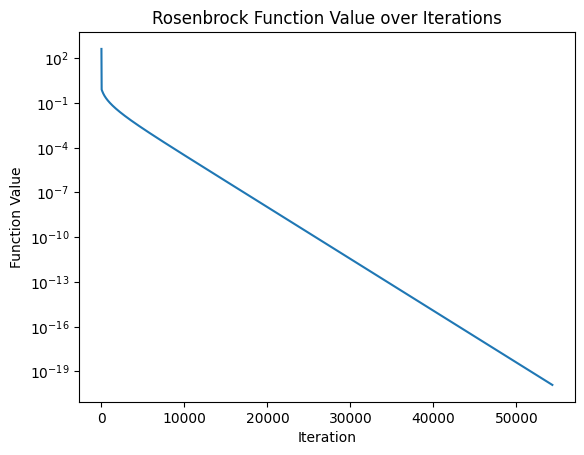

In [3]:
# Find the optimum of rosenbrock function

# Initial point
X0 = [0., 2.]

# Run gradient descent
Xopt, Xhist = GD(rosenbrock, X0, alpha=1e-3, stop_tolerance=1e-10, max_steps=int(1e6))

# Print the result
print("Found optimum at %s in %d steps (true minimum is at [1,1])" % (Xopt, len(Xhist)))

# Extract the values of the Rosenbrock function from history
values = [step[1][0] for step in Xhist]

# Plotting the function value over iterations
plt.plot(values)
plt.xlabel("Iteration")
plt.ylabel("Function Value")
plt.title("Rosenbrock Function Value over Iterations")
plt.yscale("log")  # Optional: Log scale to better see convergence
plt.show()

In [4]:
def Newton(f, theta0, alpha=1, stop_tolerance=1e-10, max_steps=1000000):
    """Performs Newton's optimization method with a simple line search."""
    theta = np.array(theta0, dtype=float)
    history = []
    step = 0

    while step < max_steps:
        # Evaluate function value, gradient, and Hessian at current theta
        val, grad, hessian = f(theta)

        # Store the current state in history
        history.append((theta.copy(), val, grad))

        # Check for convergence by the gradient's norm
        if np.linalg.norm(grad) < stop_tolerance:
            break

        # Compute the Newton step: delta = -Hessian_inv * grad
        try:
            hessian_inv = np.linalg.inv(hessian)
            delta = -hessian_inv @ grad
        except np.linalg.LinAlgError:
            print("Hessian is singular, cannot proceed with Newton's method.")
            break

        # Line search (adjust step size alpha if needed)
        theta_next = theta + alpha * delta
        theta = theta_next

        step += 1

    # Final entry in history
    history.append((theta, val, grad))
    return theta, history

# Test Newton's method on the Rosenbrock function
X0 = [0., 2.]  # Initial guess
Xopt, Xhist = Newton(rosenbrock_hessian, X0)

print("Found optimum at %s (true minimum is at [1,1])" % Xopt)


Found optimum at [1. 1.] (true minimum is at [1,1])


# Part two: MLP for MNIST Classification
In this part, we are going to use `PyTorch`. If you want to become more familiar with it, check this resource: https://www.learnpytorch.io/

#### In this homework, you need to
- implement SGD optimizer (`./optimizer.py`)
- implement forward and backward for FCLayer (`layers.py`)
- implement forward and backward for SigmoidLayer (`layers.py`)
- implement forward and backward for ReLULayer (`layers.py`)
- implement forward and backward for DropoutLayer (`layers.py`)
- implement train and test process (`solver.py`)

In [5]:
from layers import FCLayer, SigmoidLayer, ReLULayer
from solver import train, test
from optimizer import SGD

In [6]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
# Load MNIST dataset

# Converts PIL image to tensor and scales to [0, 1] and flatten it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
])

# Load MNIST dataset with the defined transform
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# One-hot encoding for labels
def decode_label(label, num_classes=10):
    return torch.nn.functional.one_hot(torch.tensor(label), num_classes=num_classes).float()

# Preprocess labels and combine with transformed images
y_train = [decode_label(label) for _, label in train_dataset]
y_test = [decode_label(label) for _, label in test_dataset]

# Convert the data into tensor datasets for training and testing
train_dataset = TensorDataset(torch.stack([img for img, _ in train_dataset]), torch.stack(y_train))
test_dataset = TensorDataset(torch.stack([img for img, _ in test_dataset]), torch.stack(y_test))

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
num_epoch = 20

criterion = nn.MSELoss()

# Build MLP with FCLayer and SigmoidLayer you've implemented in layers.py
sigmoidMLP = nn.Sequential(
    FCLayer(784, 128),
    SigmoidLayer(),
    FCLayer(128, 10)
)

# Initialize optimizer you've implemented in optimizer.py
sgd = SGD(params=sigmoidMLP.parameters(), learning_rate=0.01)

# Train the model using train function you've implemented in solver.py
sigmoidMLP = train(sigmoidMLP, criterion, sgd, train_dataloader, num_epoch, device=device)


Epoch [0] Average training loss: 0.0771, Average training accuracy: 0.4956

Epoch [1] Average training loss: 0.0556, Average training accuracy: 0.7378

Epoch [2] Average training loss: 0.0506, Average training accuracy: 0.7835

Epoch [3] Average training loss: 0.0482, Average training accuracy: 0.8046

Epoch [4] Average training loss: 0.0466, Average training accuracy: 0.8173

Epoch [5] Average training loss: 0.0456, Average training accuracy: 0.8254

Epoch [6] Average training loss: 0.0448, Average training accuracy: 0.8307

Epoch [7] Average training loss: 0.0442, Average training accuracy: 0.8344

Epoch [8] Average training loss: 0.0437, Average training accuracy: 0.8384

Epoch [9] Average training loss: 0.0432, Average training accuracy: 0.8408

Epoch [10] Average training loss: 0.0429, Average training accuracy: 0.8430

Epoch [11] Average training loss: 0.0426, Average training accuracy: 0.8455

Epoch [12] Average training loss: 0.0423, Average training accuracy: 0.8465

Epoch [1

In [9]:
# Test your model using test function you've implemented in solver.py
test(sigmoidMLP, test_dataloader, device)

The test accuracy is 0.8627.



In [10]:
# Build MLP with FCLayer and ReLULayer
reluMLP = nn.Sequential(
    FCLayer(784, 128),
    ReLULayer(),
    FCLayer(128, 10)
)

# Initialize optimizer
sgd = SGD(reluMLP.parameters(), learning_rate=0.01)

# Train the model
reluMLP = train(reluMLP, criterion, sgd, train_dataloader, num_epoch, device=device)


Epoch [0] Average training loss: 0.0712, Average training accuracy: 0.6373

Epoch [1] Average training loss: 0.0467, Average training accuracy: 0.8231

Epoch [2] Average training loss: 0.0399, Average training accuracy: 0.8589

Epoch [3] Average training loss: 0.0357, Average training accuracy: 0.8765

Epoch [4] Average training loss: 0.0327, Average training accuracy: 0.8875

Epoch [5] Average training loss: 0.0305, Average training accuracy: 0.8953

Epoch [6] Average training loss: 0.0288, Average training accuracy: 0.9011

Epoch [7] Average training loss: 0.0274, Average training accuracy: 0.9060

Epoch [8] Average training loss: 0.0262, Average training accuracy: 0.9103

Epoch [9] Average training loss: 0.0253, Average training accuracy: 0.9131

Epoch [10] Average training loss: 0.0244, Average training accuracy: 0.9162

Epoch [11] Average training loss: 0.0237, Average training accuracy: 0.9185

Epoch [12] Average training loss: 0.0231, Average training accuracy: 0.9205

Epoch [1

In [11]:
# Test the model
test(reluMLP, test_dataloader, device)

The test accuracy is 0.9313.



### Overfit the model
Try to overfit the reluMLP model. You can make the model as complex as you like, use subset of the data for training or any other approach you want.
Then add **DropoutLayer** to your model in order to reduce overfitting problem.

In [12]:
import torch.nn as nn

# Define a more complex MLP model to encourage overfitting
complex_reluMLP = nn.Sequential(
    FCLayer(784, 256),
    ReLULayer(),
    FCLayer(256, 128),
    ReLULayer(),
    FCLayer(128, 64),
    ReLULayer(),
    FCLayer(64, 10)
)

# Initialize optimizer
sgd = SGD(complex_reluMLP.parameters(), learning_rate=0.01)

# Use a smaller subset of the training data to encourage overfitting
subset_size = 500  # Use only 500 samples for training to induce overfitting
subset_train_dataloader = DataLoader(
    torch.utils.data.Subset(train_dataset, range(subset_size)),
    batch_size=32,
    shuffle=True
)

# Train the complex model on the subset
num_epoch = 20  # Increase epochs to further encourage memorization
criterion = nn.CrossEntropyLoss()  # Define a loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

complex_reluMLP = train(complex_reluMLP, criterion, sgd, subset_train_dataloader, num_epoch, device=device)

# Test the model to observe overfitting
test(complex_reluMLP, test_dataloader, device)


Epoch [0] Average training loss: 2.3196, Average training accuracy: 0.1160

Epoch [1] Average training loss: 2.2260, Average training accuracy: 0.1586

Epoch [2] Average training loss: 2.1477, Average training accuracy: 0.2223

Epoch [3] Average training loss: 2.0586, Average training accuracy: 0.3168

Epoch [4] Average training loss: 1.9621, Average training accuracy: 0.4418

Epoch [5] Average training loss: 1.8518, Average training accuracy: 0.5211

Epoch [6] Average training loss: 1.7365, Average training accuracy: 0.5832

Epoch [7] Average training loss: 1.6101, Average training accuracy: 0.6426

Epoch [8] Average training loss: 1.4875, Average training accuracy: 0.7215

Epoch [9] Average training loss: 1.3491, Average training accuracy: 0.7543

Epoch [10] Average training loss: 1.2241, Average training accuracy: 0.7770

Epoch [11] Average training loss: 1.1085, Average training accuracy: 0.7891

Epoch [12] Average training loss: 1.0017, Average training accuracy: 0.8098

Epoch [1

In [13]:
from layers import DropoutLayer

# Define the MLP model with Dropout layers to reduce overfitting
dropout_reluMLP = nn.Sequential(
    FCLayer(784, 256),
    ReLULayer(),
    DropoutLayer(0.5),  # 50% dropout rate
    FCLayer(256, 128),
    ReLULayer(),
    DropoutLayer(0.5),  # 50% dropout rate
    FCLayer(128, 64),
    ReLULayer(),
    DropoutLayer(0.5),  # 50% dropout rate
    FCLayer(64, 10)
)

# Initialize the optimizer
sgd = SGD(dropout_reluMLP.parameters(), learning_rate=0.01)

# Train the model with Dropout
num_epoch = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

dropout_reluMLP = train(dropout_reluMLP, criterion, sgd, train_dataloader, num_epoch, device=device)

# Test the model with Dropout
test(dropout_reluMLP, test_dataloader, device)



Epoch [0] Average training loss: 1.4620, Average training accuracy: 0.4889

Epoch [1] Average training loss: 0.7382, Average training accuracy: 0.7711

Epoch [2] Average training loss: 0.5631, Average training accuracy: 0.8368

Epoch [3] Average training loss: 0.4718, Average training accuracy: 0.8667

Epoch [4] Average training loss: 0.4164, Average training accuracy: 0.8863

Epoch [5] Average training loss: 0.3711, Average training accuracy: 0.9000

Epoch [6] Average training loss: 0.3419, Average training accuracy: 0.9093

Epoch [7] Average training loss: 0.3144, Average training accuracy: 0.9165

Epoch [8] Average training loss: 0.2947, Average training accuracy: 0.9213

Epoch [9] Average training loss: 0.2795, Average training accuracy: 0.9267

Epoch [10] Average training loss: 0.2653, Average training accuracy: 0.9298

Epoch [11] Average training loss: 0.2502, Average training accuracy: 0.9351

Epoch [12] Average training loss: 0.2415, Average training accuracy: 0.9365

Epoch [1